# Soccer Analytics Handbook Code Samples
---

This is an extensive update to the original code samples that I provided with the 2020 version of the [Soccer Analytics Handbook](https://github.com/devinpleuler/analytics-handbook) that I published on GitHub during the pandemic.

Since then, there have been various changes in the soccer analytics software ecosystem that have significantly changed what I believe are best practices for working with public soccer data in the python enviornment. Additionally, when I originally shared the handbook I did not anticipate the level of attention that it recieved. This attention established the handbook's code as reference material for many beginniners. Unfortunatly, a lot of the code wasn't really good – and now in 2023 it's also very out-of-date. Hopefully this rectifies this a bit.

This version does not require any installation of my own libraries, instead leaning on various *more professional* libraries such as [`statsbombpy`](https://github.com/statsbomb/statsbombpy), [`mplsoccer`](https://github.com/andrewRowlinson/mplsoccer), and [`kloppy`](https://github.com/PySport/kloppy) to accomplish a lot of the plumbing. It can run easily in Google Colab, but can also be cloned to a local enviornment.

As with the original code samples, my hope is that this will be a living and breathing document that evolves over time. Pull requests on GitHub are very welcome, and I encourage any proposed changes that you believe better represents best practices.

# Setup
---
Run this code block to install `statsbombpy`, `mplsoccer`, and `kloppy`. And import the primary data science packages (e.g. `numpy`, `pandas`, etc.) that most of the code samples require. It also does a few other things like creates some custom colormaps and does some visual configuration.

### Packages to Install

In [1]:
!pip install statsbombpy==1.12 --quiet
!pip install mplsoccer==1.2.4 --quiet
!pip install kloppy==3.14.0 --quiet
!pip install tqdm==4.66.4 --quiet
!pip install scikit-learn==1.5.0 --quiet
!pip install xgboost==2.0.3 --quiet
!pip install bezier===2023.7.28 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.0/186.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00


### Visual Configuration

In [2]:
%config InlineBackend.figure_format = 'retina'
figsize = (9, 6)

## Imports

In [3]:
from statsbombpy import sb
import mplsoccer as mpl
from kloppy import metrica

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from tqdm import tqdm

## Colors

In [6]:
from matplotlib.colors import ListedColormap
def bulid_cmap(x, y):
    r,g,b = x
    r_, g_, b_ = y
    N = 256
    A = np.ones((N, 4))
    A[:, 0] = np.linspace(r, 1, N)
    A[:, 1] = np.linspace(g, 1, N)
    A[:, 2] = np.linspace(b, 1, N)
    cmp = ListedColormap(A)

    B = np.ones((N, 4))
    B[:, 0] = np.linspace(r_, 1, N)
    B[:, 1] = np.linspace(g_, 1, N)
    B[:, 2] = np.linspace(b_, 1, N)
    cmp_ = ListedColormap(B)

    newcolors = np.vstack((cmp(np.linspace(0, 1, 128)),
                            cmp_(np.linspace(1, 0, 128))))
    return ListedColormap(newcolors)

In [7]:
blue, red = (44,123,182), (215,25,28)
blue = [x/256 for x in blue]
red = [x/256 for x in red]
diverging = bulid_cmap(blue, red)
diverging_r = bulid_cmap(red, blue)

# Code Examples

## Visualization

### Prepare the Data

In [13]:
matches = sb.matches(competition_id=43, season_id=106)

Call the `matches` method from the `sb` module. The method queries the Statsbomb API to access all of the matches that have a certain competition and season ID. The arguments provided here will access all matches in the 2022 FIFA World Cup.

> Notice: you might see a `NoAuthWarning`. This is because you're acessing the StatsBomb open data. If you have a subscription, you can actually pass credentials to these module functions and access your own data. You can quiet these warnings in python if they are annoying.

In [9]:
matches.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,...,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,...,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,...,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2


The matches method returns a Pandas DataFrame object, which you can visualize in various ways including calling the `head` method which takes an argument of the total number of rows that you would like to see.

In [10]:
final = matches[matches['competition_stage'] == "Final"].iloc[0]

We filter this DataFrame to return a new DataFrame that only contains rows where the value of the `competition_stage` column is equal to `Final`.

The expression `matches['competition_stage'] == "Final"` creates a boolean mask with `True` values where the condition is met. This mask is then used to index the original DataFrame resulting in a new DataFrame that contains only the rows where the condition is met.

Of course, there is only one World Cup Final match, so we grab the 0th row using the `.iloc` accessor and assign it to a new variable named `final`. At this point, `final` is a Pandas Series object.

In [11]:
match_id = final.loc['match_id']

We select the `match_id` column from the `final` object usng the `.loc` accessor and assign it to a new variable,

In [12]:
events = sb.events(match_id = match_id)

KeyboardInterrupt: 

Similar to the `sb.matches` method, we use `sb.events` to access all of the events in a particular match, specified by a certain match id. In this example, we are feeding it the `match_id` that corresponds to the FIFA World Cup Final match in 2022 between Argentina and France.

### Passing Chart

In [ ]:
passes = events[(events['type'] == "Pass") &
                (events['player_id'] == 5503)]

Similar to how we filtered the `matches` DataFrame object for the `Final` match, we filter the events DataFrame object on multiple conditions, including specifying that the event `type` must be `Pass` and the `player_id` must by `5503`, which corresponds to Lionel Messi.

In [ ]:
coordinates = passes[['location', 'pass_end_location']]

After filtering the passes DataFrame, we assign the location and pass_end_location columns to a new DataFrame named coordinates

In [ ]:
x1, y1 = np.array(coordinates['location'].tolist()).T
x2, y2 = np.array(coordinates['pass_end_location'].tolist()).T

We extract the location and pass_end_location x/y data from the coordinates DataFrame and convert it to a list using the built-in pandas method tolist.

Then, we convert the list into a Numpy array and perform a transpose operation (using `.T`) that switches the rows and columns of the array so that it can easily be unpacked into x and y lists.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)

p = pitch.arrows(x1, y1, x2, y2, alpha=0.4, color=blue,
                 headaxislength=3, headlength=3, headwidth=4, width=2, ax=ax)

We create a Pitch object and assign it to the variable pitch.

Then, similar to how you would use plt.subplots(...) in Matplotlib, we create a figure and an axis object by invoking the draw method on the Pitch object.

Next, we invoke the arrows method, feeding it the pass location lists that we generated above. We also attach various cosmetic attributes pass. We also need to pass it the axis object (ax=ax).

### Shot Chart

In [ ]:
shots = events[(events['type'] == "Shot") &
               (events['team'] == "Argentina") &
               (events['shot_type'] != "Penalty")]

Similar to how we filtered the event DataFrame for Messi's passes, you can easily filter for Argentinian shots that were not penalties.

In [ ]:
x, y = np.array(shots['location'].tolist()).T
xg = np.array(shots['shot_statsbomb_xg'].tolist())
goal = [red if g == "Goal" else 'black' for g in shots['shot_outcome'].to_list()]

From the filtered dataframe `shots` we grab a couple useful bits of information.

First we convert the shot locations to a list and transpose the data so it unpacks into `x` and `y` variables.

We grab the Expected Goal values and stick it into the `xg` variable.

And finally, we use a list comprehension to iterate through shot outcomes and generate a list that we will use to color our shots. Red if it's a goal, and black if it's not.



In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
p = pitch.scatter(x, y, s=xg*100, c=goal, alpha=0.8, ax=ax)

Similar to how we plotted passes in the previous example, we create a new Pitch and feed the various attributes for population. In particular, pay attention to how we set the size (`s`) attribute to the Expected Goal value (plus a scaling factor of 100 for aesthetics) and the color (`c`) attribute to the outcome of each shot.

### Heat Map (Event Data)

In [ ]:
arg_events = events[~pd.isna(events['location']) &
                    (events['team'] == "Argentina")]

Extract all events that have a location for Argentina and store in seperate pandas DataFrames.



In [ ]:
x, y = np.array(arg_events['location'].tolist()).T

Grab the location data for each event, convert to a numpy array, and transpose it such that it unpacks seperate `x` and `y` arrays.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
k = pitch.kdeplot(x, y, cmap='Blues', fill=True, levels=10, alpha=0.8, ax=ax)

Use the built-in `kdeplot` on the `Pitch` object to construct a Kernel Density Estimation plot on top of the field. The `kdeplot` implementation uses the `seaborn` package.

## Clustering


### Prepare the Data

In [ ]:
matches_ = matches.to_dict(orient='records')

For easy iteration, we convert the `matches` DataFrame from earlier into a dictionary using a built-in pandas method `to_dict`. Specifying the orientation to `records` makes it much easier to work with for our purposes.


In [ ]:
n_matches = 15

For the sake of reasonable processing time, we only load a subset of the matches for processing.

In [ ]:
all_events = []
for m in tqdm(matches_[0:n_matches]):
    events = sb.events(match_id = m['match_id'])
    passes = events[(events['type'] == "Pass")]
    coordinates = passes[['location', 'pass_end_location']]
    x1, y1 = np.array(coordinates['location'].tolist()).T
    x2, y2 = np.array(coordinates['pass_end_location'].tolist()).T
    coords = np.vstack((x1, y1, x2, y2)).T
    all_events.extend(coords)

The block of code borrows concepts from the earlier examples to filter and extract relevant information. The only previously unused function at this point in the notebook is `vstack` which, stacks multiple numpy arrays vertically. We then transpose to put all the spatial components in their own column.

In [ ]:
df = pd.DataFrame(all_events, columns=['x1', 'y1', 'x2', 'y2'])
df.head(3)

We stick this all back into a new pandas DataFrame named `df`, which is a commonly used variable name for pandas DataFrames.

### K-Means

In [ ]:
from sklearn.cluster import KMeans

`scikit-learn` has a k-means clustering implementation that we will borrow from.

In [ ]:
model = KMeans(n_clusters=50)
features = df[['x1', 'y1', 'x2', 'y2']]
fit = model.fit(features)

You can get quite far with simply fitting the model on the four passing coordinates in the DataFrame that we constructed.

Here we have specificed `n_clusters=50`, but it can handle a few more, or less.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
for coords in fit.cluster_centers_:
  p = pitch.arrows(*coords, alpha=0.5, color=blue, ax=ax,
                   headaxislength=2, headlength=2, headwidth=3, width=4)

After fitting the `KMeans` model, the `fit` residual has various attributes that we can investigate. The most important are the cluster centers, accessed via `cluster_centers_`.

For each cluster center, we draw an arrow on the `pitch` object. Notice how we unpack the `coords` variable with an asterick to ease of use.

### Gaussian Mixture Model

GMM's aren't used as much in Soccer Analytics as they should be. They're massively useful in various situations and they're super easy to train. Soccer is filled with many non-linear relationships (e.g. passing density surfaces), and GMM's are a computationally cheap and reasonably robust way to model them. Kernel-based non-parametric methods or neural networks might be better suited when otimizing for accuracy, but they have a quite a bit more overhead. And, you can easily resample from them!

#### Fitting the Model

In [ ]:
from sklearn.mixture import GaussianMixture

`scikit-learn` also has a GMM implementation. Most `scikit-learn` models have similar programming interfaces. Notice how we build and train the model in almost exactly the same fashion.

Here we've decided to only use `x2` and `y2` attributes as they won't cluster around areas such as the 6-yard-box from goal kicks.

In [ ]:
n_components = 40

In [ ]:
gmm = GaussianMixture(n_components=n_components)
features = df[['x2', 'y2']]
fit = gmm.fit(features)

As suggested prior, this `scikit-learn` model is fit in almost the same exact fashion as the k-means model.

#### Plotting

In [ ]:
from matplotlib.patches import Ellipse

Gaussians are elliptical, so we import `Ellipse` from `matplotlib.patches` for plotting purposes.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    eig_val, eig_vec = np.linalg.eig(cov)
    angle = np.arctan2(*eig_vec[:,0][::-1])
    e = Ellipse(mean,
                2*np.sqrt(eig_val[0]),
                2*np.sqrt(eig_val[1]),
                angle=np.degrees(angle),
                color=blue)
    e.set_alpha(0.5)
    ax.add_artist(e)

Similar to how we interated over the cluster centers on the k-means model, we iterate over the GMM components and grab their means and covariance matrices stored in the `means_` and `covariance_` object attributes.

We find the eigenvalues and eigenvectors of each covariance matric using a numpy linear algebra operation, and find the angle of rotation of the first eigenvector using some trigonometry.

These features are required for plotting the Ellipse at the correct length, width, and angle.

#### Resampling from GMM

In [ ]:
samples = gmm.sample(5000)

One really neat feature of GMM's is that you can generate new data from the fitted model. This function creates `5000` new pairs of x and y coordinates and stores it in the `samples` variable.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
s = pitch.scatter(*samples[0].T, alpha=0.4, color=blue, ax=ax)

We can easily plot these new `samples` using pretty much the same code we used to populate shot charts.

#### Calculating PDF

This is a bit advanced subsection, and frankly I don't understand all of the code myself. ChatGPT did some heavy lifting here.

But in summary: you can evaluate a GMM as a Probability Density Function across a grid, and apply a contourplot to overlay on top of a `pitch` object..

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
x_min, x_max = 0, 120
y_min, y_max = 0, 80
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 120),
                     np.linspace(y_min, y_max, 80))

Z = np.zeros((xx.shape[0], xx.shape[1], n_components))
for i, (mean,
        covariance,
        weight) in enumerate(zip(gmm.means_,
                                 gmm.covariances_,
                                 gmm.weights_)):

    Z[:,:,i] = weight * multivariate_normal.pdf(
      np.column_stack([xx.ravel(), yy.ravel()]).reshape(
          xx.shape + (2,)), mean=mean, cov=covariance)

Z = Z.sum(axis=-1)
Z = Z.reshape(xx.shape)

We iterate across all of the GMM components (and their means, covariances, and weights) and use the `multivariate_normal` function from `scipy.stats` to calculate the pdf at each point in the grid.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
plot = ax.contourf(xx, yy, Z, levels=10,
                   cmap="Blues", alpha=0.8, antialiased=True)

The `mplsoccer` `Pitch` object does not have built-in contour support, but we can still just apply the contour estimate to the same `matplotlib` axis.

## Model Pass Difficulty

### Prepare the Data

In [ ]:
all_events = []

for m in tqdm(matches_):
    events = sb.events(match_id = m['match_id'])
    passes = events[(events['type'] == "Pass")]
    x1, y1 = np.array(passes['location'].tolist()).T
    x2, y2 = np.array(passes['pass_end_location'].tolist()).T
    outcome = np.array(
        [1 if pd.isna(o) else 0 for o in passes['pass_outcome'].values]).T
    evs = np.vstack((x1, y1, x2, y2, outcome)).T
    all_events.extend(evs)

This time, we load the entire FIFA World Cup 2022 data into our environment. When building something like a pass difficulty model, we really need a good amount of data.

In [ ]:
df = pd.DataFrame(all_events, columns=['x1', 'y1', 'x2', 'y2', 'outcome'])

We load all of our data into a pandas DataFrame `df`

In [ ]:
X = df[['x1', 'y1', 'x2', 'y2']]
y = df['outcome']

Seperate our training features from our target variable.

As is convention, `X` is used for the features and `y` is used for the target variable.

### Split Training/Test Data Sets

In [ ]:
from sklearn.model_selection import train_test_split

From `scikit-learn`, we import `train_test_split` to help us seperate our training data from our test data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the data into training and test data sets, with the `test_size` representing 20% of the overall sample.

### Fit XGBoost Model

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(random_state=0)
fit = model.fit(X_train, y_train)

Import `xgboost` and train a vanilla classifier with the segmented training data.

In [ ]:
y_probs_train = model.predict_proba(X_train)[:, 1]
y_probs_test = model.predict_proba(X_test)[:, 1]

Use the fitted model to make predictions on both the training and test data set for the purposes of validation.

### Evaluate Model using ROC & AUC

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

Import some methods for evaluating classification models from `scikit-learn`

In [ ]:
auc_train = roc_auc_score(y_train, y_probs_train)
auc_test = roc_auc_score(y_test, y_probs_test)

Evaluate the `ROC` and `AUC` for the predictions on both the training and test data sets.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_probs_train)
fpr_, tpr_, thresholds_ = roc_curve(y_test, y_probs_test)

plt.plot(fpr, tpr, label='Train - ROC curve (area = {:.3f})'.format(auc_train))
plt.plot(fpr_, tpr_, label='Test - ROC curve (area = {:.3f})'.format(auc_test))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

As expected, the model performs slightly better on the data set that it was trained on. But, the model performs quite well on the test data set too.

### Plot Examples

In [ ]:
y_probs = model.predict_proba(df[['x1', 'y1', 'x2', 'y2']])[:, 1]
df['difficulty'] = y_probs

This estimates the difficulty of every pass in the DataFrame and assigns it to a new column named `difficulty`

In [ ]:
from matplotlib import colormaps as cm
cmap = cm['coolwarm_r']

This imports a colormap named `coolwarm` (actually a reverse one named `coolwarm_r`) so we can map numbers to colors easily.

In [ ]:
coords = df[['x1', 'y1', 'x2', 'y2']].values[100:200].T
colors = cmap(df['difficulty'].values[100:200])

This loads `100` pairs of coordinates and pass difficulties mapped to a color.

In [ ]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
p = pitch.arrows(*coords, alpha=0.8, cmap='coolwarm_r', color=colors,
                  headaxislength=3, headlength=3, headwidth=4, width=2, ax=ax)
plt.colorbar(p, shrink=0.6)

We plot the `100` passes, and color them by the difficulty of the pass. Notice that the longer passes tend to be more difficult, and the shorter passes a bit more blue.

However, you can also notice some over-fitting here. Pass destinations that intersect the field perimeter have a `0.0` difficulty. The model seems to have learned that passes with this attribute will never complete successfully.

## Tracking Data

### Prepare the Data

In [14]:
dataset = metrica.load_open_data(
    match_id=1,
    coordinates="metrica"
) # This takes about 60 seconds

Kloppy allows for easy access to Metrica's open data, which is the only repository of full tracking data that I'm aware of. This can be done with the `load_open_data` method on the `metrica` module.

In [15]:
df = dataset.to_df()

We can load this data directly into a `pandas` data frame for ease of use.

In [16]:
df.head(5)

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,home_11_x,...,home_13_d,home_13_s,away_28_x,away_28_y,away_28_d,away_28_s,home_14_x,home_14_y,home_14_d,home_14_s
0,1,0.00,1,None,None,0.45472,0.61291,None,None,0.00082,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0.04,2,None,None,0.49645,0.59344,None,None,0.00096,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0.08,3,None,None,0.53716,0.57444,None,None,0.00114,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0.12,4,None,None,0.55346,0.57769,None,None,0.00121,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0.16,5,None,None,0.55512,0.59430,None,None,0.00129,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


We can take a quick glance at the shape of the tracking data with a `pd.head` call. Notice that individual `x` and `y` coordinates are stored in different columns for each player.

Notice that not all cells are populated (you see a lot of `NaN`s) – this is because it includes players who may not be on the field yet and are possibly not present during a particular frame.

In [17]:
frame_rate = 25

We store the `frame_rate` in a variable, which is useful for adjusting various things such as per-frame player velocity into more understandable scales (like `m/s`).

In [18]:
length, width = 105, 68
adjust = np.array([length, width])

The `length` and `width` of the field are stored here, and we create a adjustment factor that is useful for converting from the `metrica` field coordinate system (which goes from `0` to `1` in both the `x` and `y` dimensions) to something a bit more useful.

### Plot Player Paths

In [19]:
metrica_attrs = {"pitch_type": "metricasports",
                 "pitch_length": length,
                 "pitch_width": width,
                 "line_color": "black",
                 "linewidth": 1,
                 "goal_type": "circle"}

For the `mplsoccer` `Pitch` object, we've mostly bee using default parameters so far. We've gotten away with this because `statsbomb` is the default `pitch_type` for the module. Here we set a dictionary of keyword arguments that we will unpack into `Pitch` object constructors so it works more natively with `metrica` data.

In [20]:
hj = list(set([x.split("_")[1] for x in df.columns if "home" in x]))

`hj` is generated via a list comprehension that determines a unique list of numbers in the `df` columns that contains the word `home`. These are the jersey numbers of all of the `home` players.

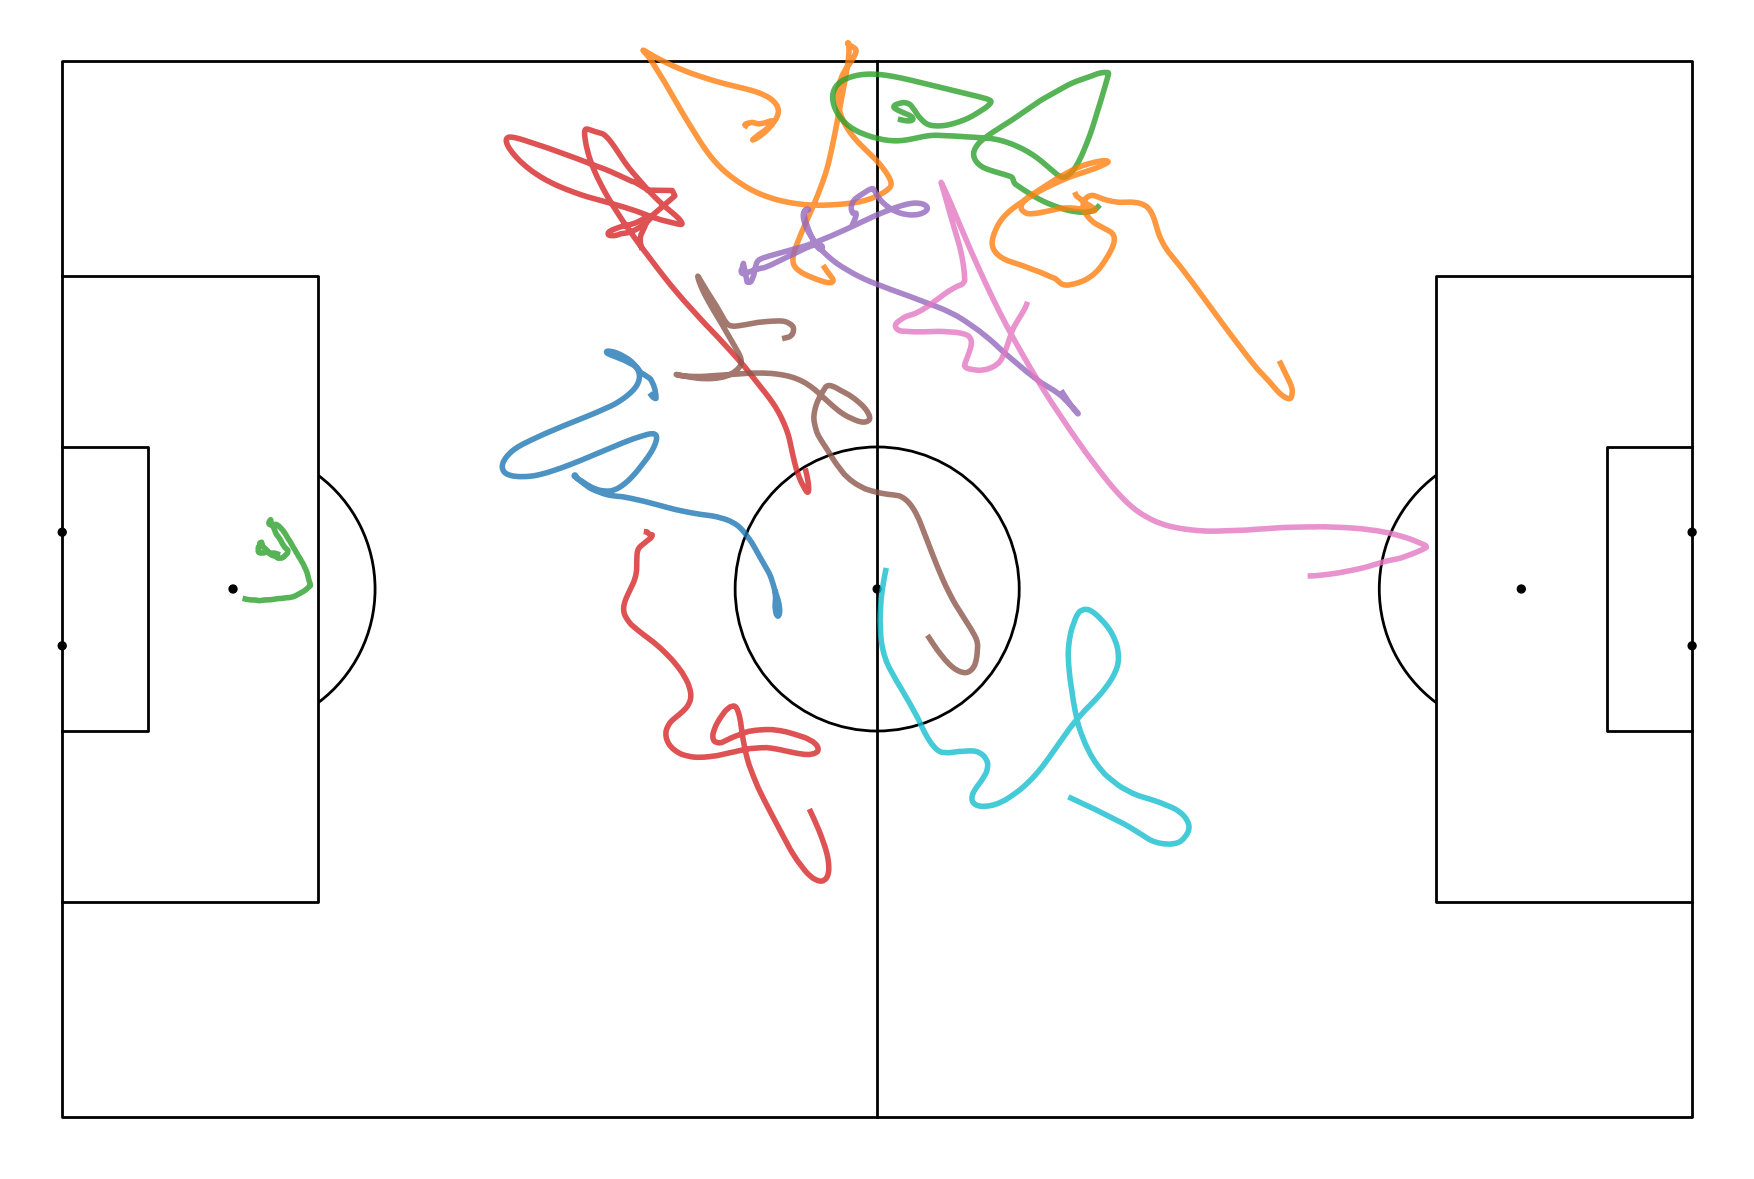

In [21]:
start, stop = 4000, 5000 # Frame Range

pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)

for j in hj:
    path = df[['home_{}_x'.format(j),
               'home_{}_y'.format(j)]].values[start:stop]
    pitch.plot(*path.T, lw=2, alpha=0.8, ax=ax)

This code sample plots the trajectory of all home players from frames `4000` to `5000`.

Notice how the metrica attributes are unpacked into the `Pitch` construction.

### High Intensity Runs

Counting the number of runs that a player makes during a game is a common ask for data analysts working with tracking data. Below is a very simple and unsophsticated method for couting these instances for a a team during a match.

In [22]:
paths = []
for j in hj:
    path = df[['home_{}_x'.format(j), 'home_{}_y'.format(j)]].values * adjust
    paths.append(path)

First, we must extract the `x` and `y` coordinates from the DataFrame for each player, and apply an adjustment factor to convert us from the metrica coordinate system into actual euclidian space.

In [23]:
all_runs = []
speed_threshold = 6
sustained_frame_threshold = 10
running = False

for path in paths:
    runs = []
    for i, coord in enumerate(path):

        displacement = path[i-1]
        speed = np.linalg.norm(coord - displacement) * frame_rate
        if speed > speed_threshold:
            if not running:
                running = True
                frame_start = i
        else:
            if running:
                running = False
                frame_end = i
                if frame_end > frame_start + sustained_frame_threshold:
                    runs.append((frame_start, frame_end))
    all_runs.append(runs)

This code steps through every single coordinate for a player over time, calculating the positional displacement on a frame-by-frame level. When multiplied by the frame rate, we can get an estimate of a player's instantaneous speed.

This is a bit dangerous, as we're only comparing frame-by-frame and imperfections in the data can sometimes lead to unrealistic fluctuations in a player speed. This is particularly dangerous as it can be exacerbated when you're evaluating higher-order derivatives of location such as acceleration.

As we iterate frame-by-frame, we check if the speed exceeds our trhreshold (set as `speed_threshold = 6` for a minimum number of frames (set as `sustained_frame_threshold = 10`). We stick the starting and ending frame numbers into a tuple and append it to our `runs` list for accumulation.

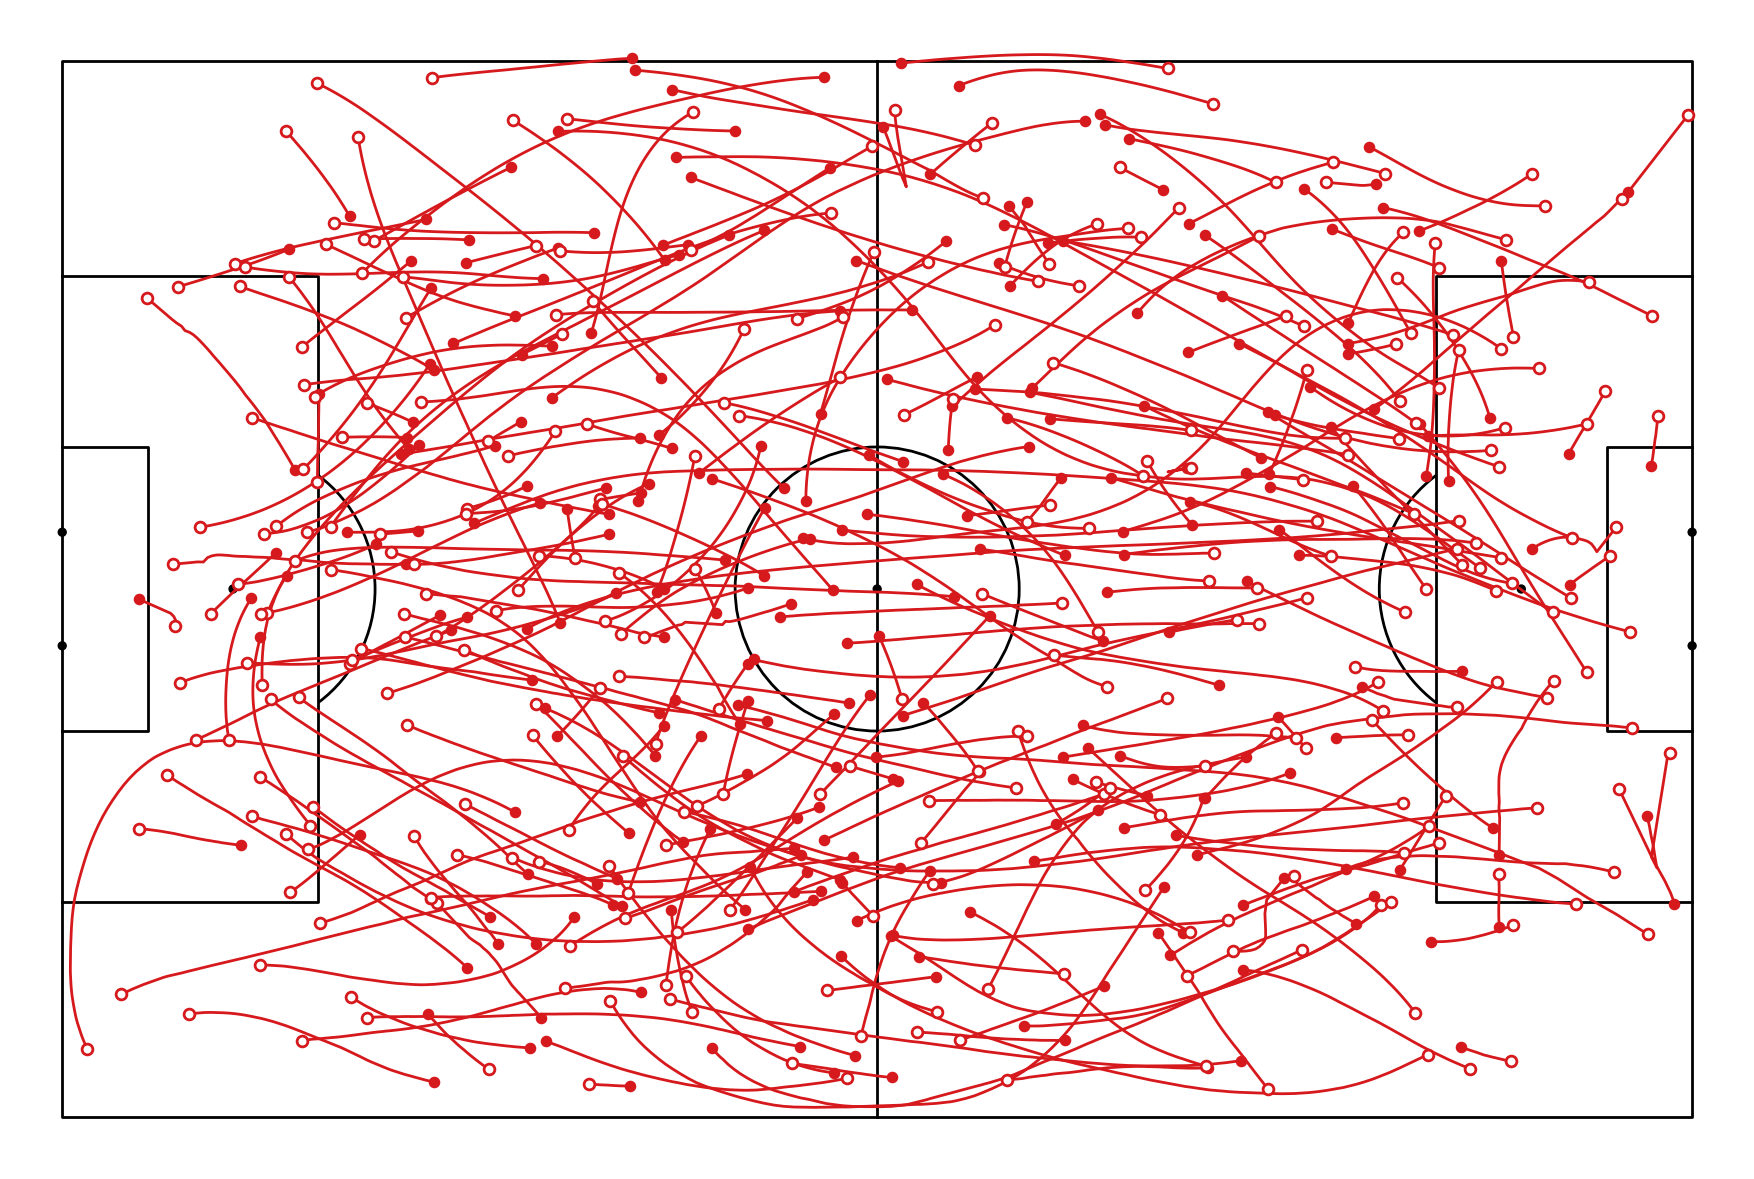

In [24]:
pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)

for i, path in enumerate(paths):
    for (start, stop) in all_runs[i]:
        unadjust = np.array(paths[i][start:stop]) * (1 / adjust)
        pitch.plot(*unadjust.T, lw=1, c=red, ax=ax, zorder=1)
        pitch.scatter(*unadjust[0].T, s=10, color=red, ax=ax)
        pitch.scatter(*unadjust[-1].T, s=15,
                    facecolor="white", edgecolor=red, zorder=2, ax=ax)


We can easily plot these runs by slicing our `path` array by the `start` and `stop` frames to create each individual run path.

Note: we do have to "unadjust" the coordinate data before plotting to get back to the `metrica` coordinate system so it plays nicely with our `mplsoccer` plot.

We add a couple dots (filled circle for start, open circle for end) to denote the extremeties of the run.

### Bezier Curves

Fitting bezier curve to tracking segments can be quite useful for interpretation, serving as a bit of a dimensionality reduction.

In [25]:
def get_bezier_parameters(X, Y):
    T = np.linspace(0, 1, len(X))
    M = np.column_stack([(1 - T) ** 2, 2 * T * (1 - T), T ** 2])
    points = np.column_stack((X, Y))
    return np.linalg.pinv(M) @ points

This function calculates the parameters of a quadratic (second degree) Bezier curve that fits a set of points.

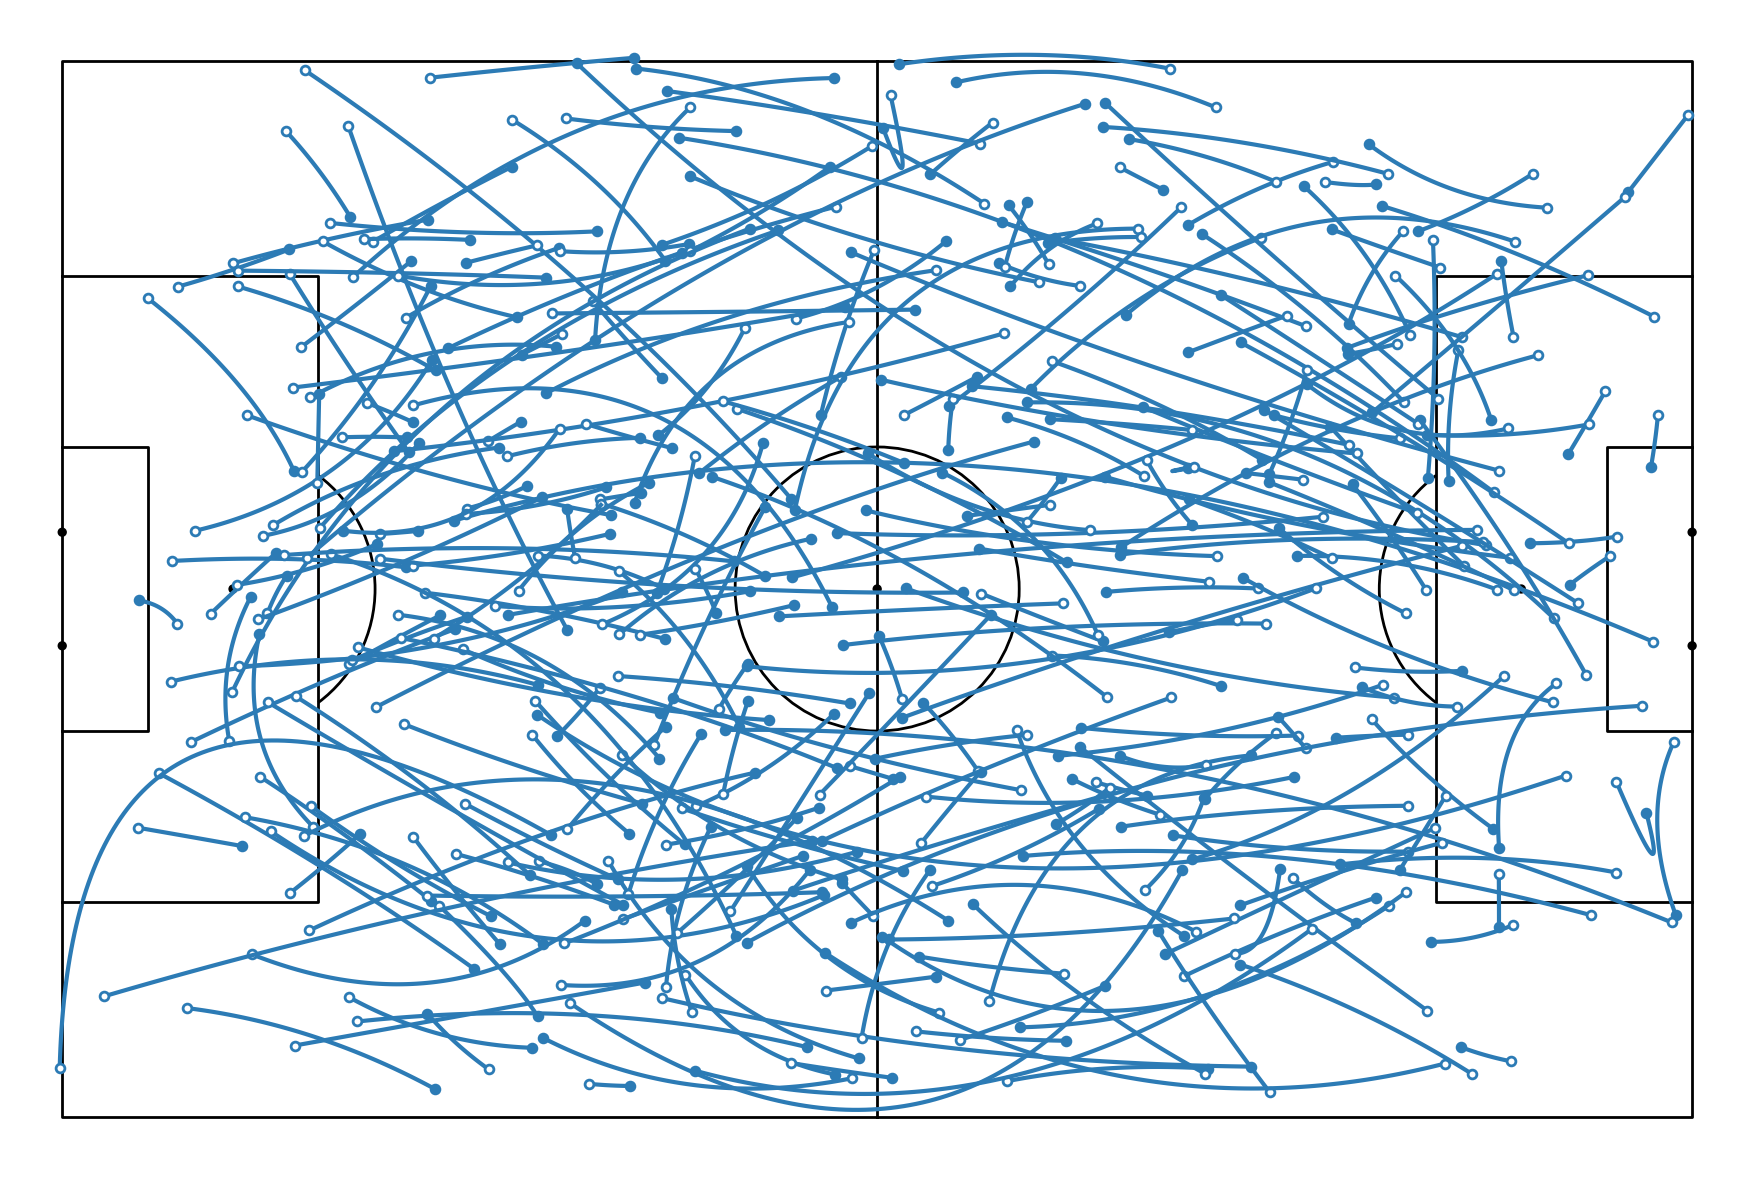

In [26]:
import bezier

pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)

beziers = []

for i, path in enumerate(paths):
    for (start, stop) in all_runs[i]:
        unadjust = np.array(path[start:stop]) * (1 / adjust)

        params = np.asarray(get_bezier_parameters(*unadjust.T))
        beziers.append(params.T.flatten())

        curve = bezier.Curve(params.T, degree=2)
        curve.plot(num_pts=100, ax=ax, color=blue)

        pitch.scatter(params[0][0], params[0][1], s=10, color=blue, ax=ax)
        pitch.scatter(params[2][0], params[2][1], s=10, color=blue, ax=ax, facecolor="white", zorder=2)

Using the run paths detected in the previous segment, we fit and plot a Bezier curve for each individual run.

And, stores the parameters of each Beizer curve in the `bezier` list.

In [27]:
from sklearn.cluster import KMeans # Actually already imported, but for reference
kmeans = KMeans(n_clusters=10, random_state=0).fit(beziers)

Because there are only 3 pairs of control points for each Bezier, no matter the length of the run, we can easily perform some clustering to identify some underlying structure in the dataset.

Here, we utilize a simple `KMeans` clustering, with `n_clusters=10`.

In [28]:
cluster_of_interest = 4

preds = kmeans.predict(beziers)
matches = np.where(preds == cluster_of_interest)

Here, we arbitrarily select `cluster_of_interest=9` and extract all of the runs in that cluster.

<Axes: >

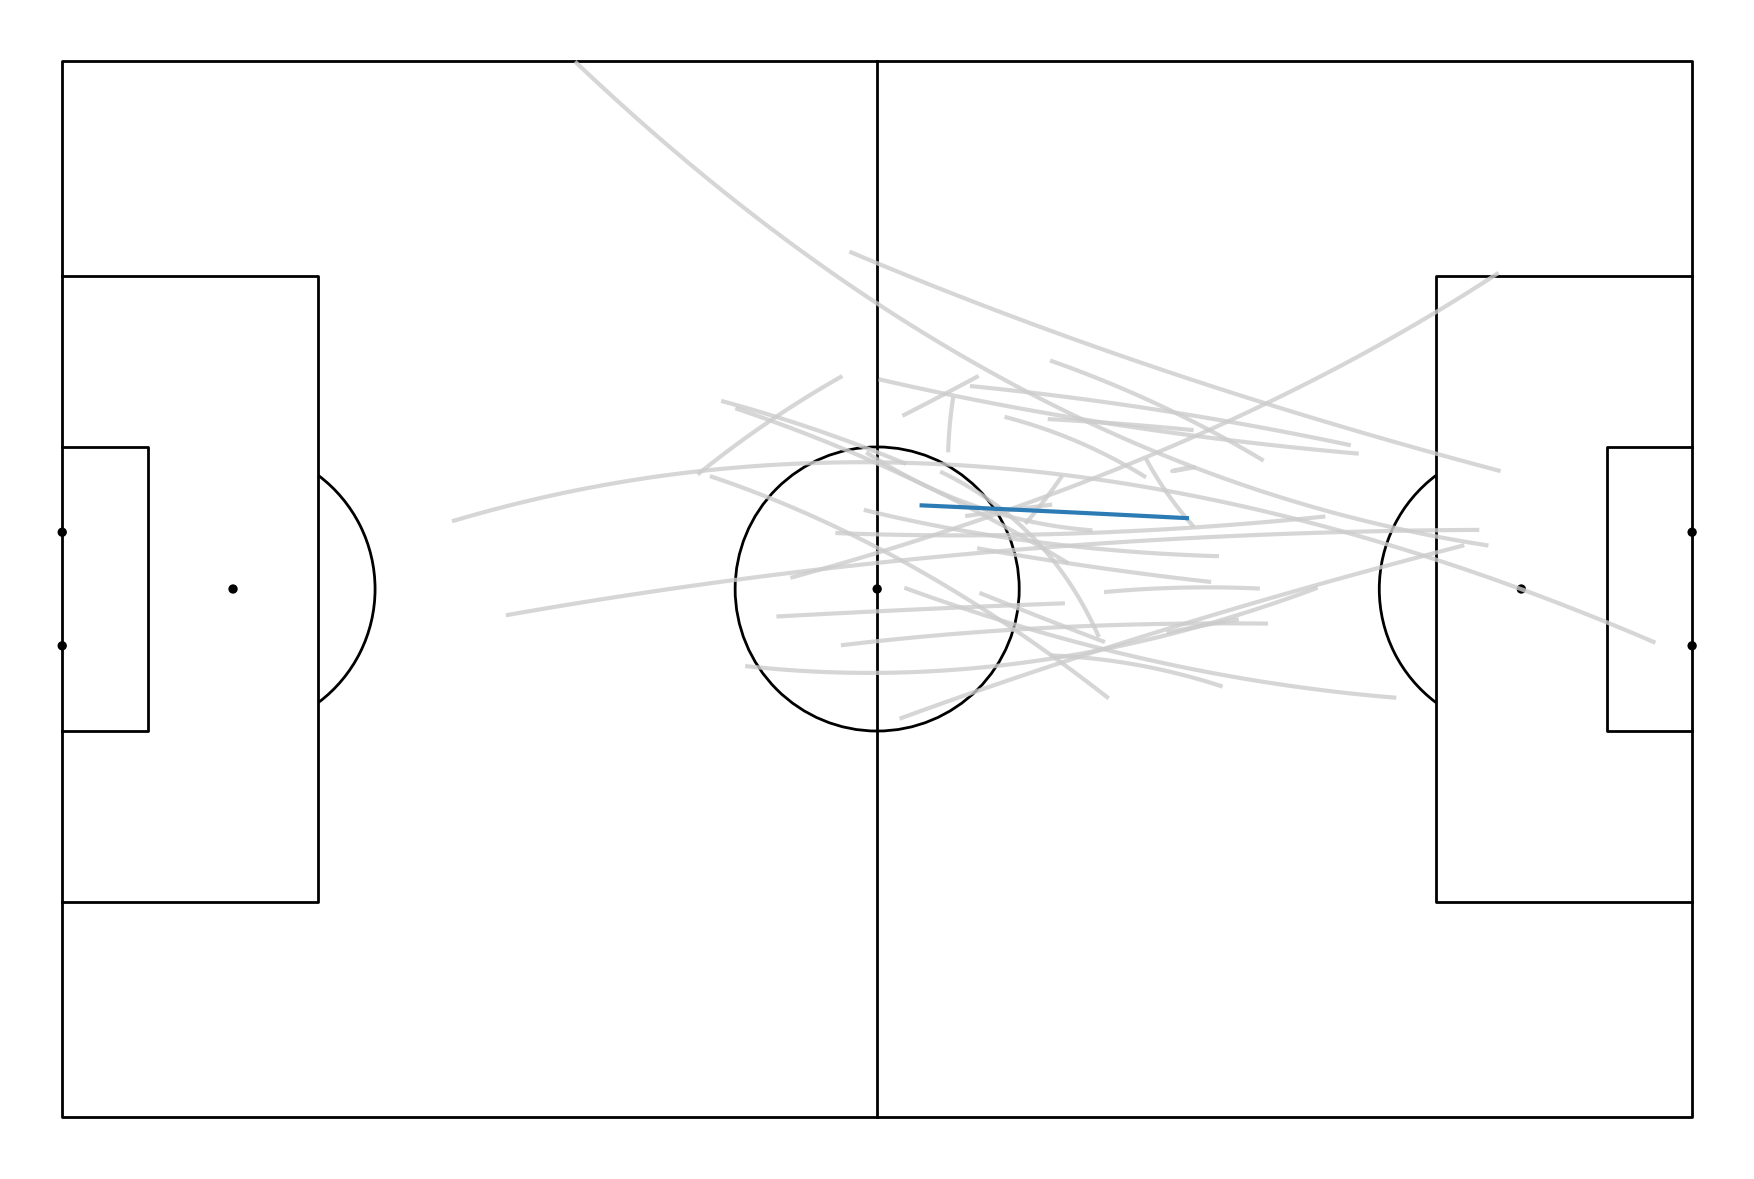

In [29]:
pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)

for m in matches[0]:
    params = beziers[m].reshape((2,3))
    curve = bezier.Curve(params, degree=2)
    curve.plot(num_pts=100, ax=ax, color="#ccc", alpha=0.8)

center = kmeans.cluster_centers_[cluster_of_interest].reshape((2,3))
curve = bezier.Curve(center, degree=2)
curve.plot(num_pts=100, ax=ax, color=blue)

Here we cluster all of the runs that belong to the `cluster_of_interest` but also the cluster center, which can be extracted from the `kmeans` object.

The limited sample size makes this a bit of a toy example, but this can be quite useful for categorizing run types across an entire season of data.

### Confidence Regions and Centroid Normalization

Plotting confidence regions around player location is a great alternative to simply plotting their average positions.
This provides an understanding of just how variable a player's position might be.

In [30]:
fh = df[df['period_id'] == 1] # Grab data from just the first half
team = []
for j in hj:
    track = fh[['home_{}_x'.format(j), 'home_{}_y'.format(j)]].values
    team.append(track)
tracks = np.array(team)
print(tracks.shape)

(14, 71268, 2)


This creates a new `df` that only looks at frames that belong to the first half (`period_id=1`). Otherwise, you would have to perform some additional normalization that adjusts for the flipping of the field at halftime (not too difficult).

We parse through the home player jersey numbers, and build individual tracks and create a home team tensor named `tracks`. Notice that the shape of the tracks numpy array is `(10, 71268, 2)`.

In [31]:
centroids = np.nanmean(tracks, axis=0)
adjusted = tracks - centroids + np.array([0.5, 0.5])

We can get framewise centroids by averaging the team tracks across `axis=0` (i.e. the frames).

Next, we can get an adjusted team tensor by subtracking the centroids from the raw tracks. We also have to perform an additional `metrica`-specific adjustment and add `[0.5, 0.5]` to each row to normalize the relative position to the center midfield dot.

In [32]:
from scipy.stats import chi2

def confidence_region(player_track, confidence_level=0.95):

    cov = np.cov(player_track.T)
    eig_val, eig_vector = np.linalg.eig(cov)
    rads = np.arctan2(eig_vector[1, 0], eig_vector[0, 0])
    scale_factor = np.sqrt(chi2.ppf(confidence_level, df=2))

    return {
        "xy": np.mean(player_track, axis=0),
        "width": np.sqrt(eig_val[0]) * scale_factor,
        "height": np.sqrt(eig_val[1]) * scale_factor,
        "angle": np.degrees(rads),
    }

This `confidence_region` function takes individual player tracks and returns the attributes that are needed to construct a `matplotlib.patches.Ellipse` object.

First, we construct a covariance matrix using `np.cov`, and calculate the eigenvalues and eigenvectors of the covariance matrix using `np.linalg.eig()`.

We use those values for various things, including the calculation of the angle (in radians) the distribution is skewed, but also the width and height of the distribution.

You can also use the `confidence_level` as a scaling factor to (effectively) adjust the size of the distribution.

NameError: name 'Ellipse' is not defined

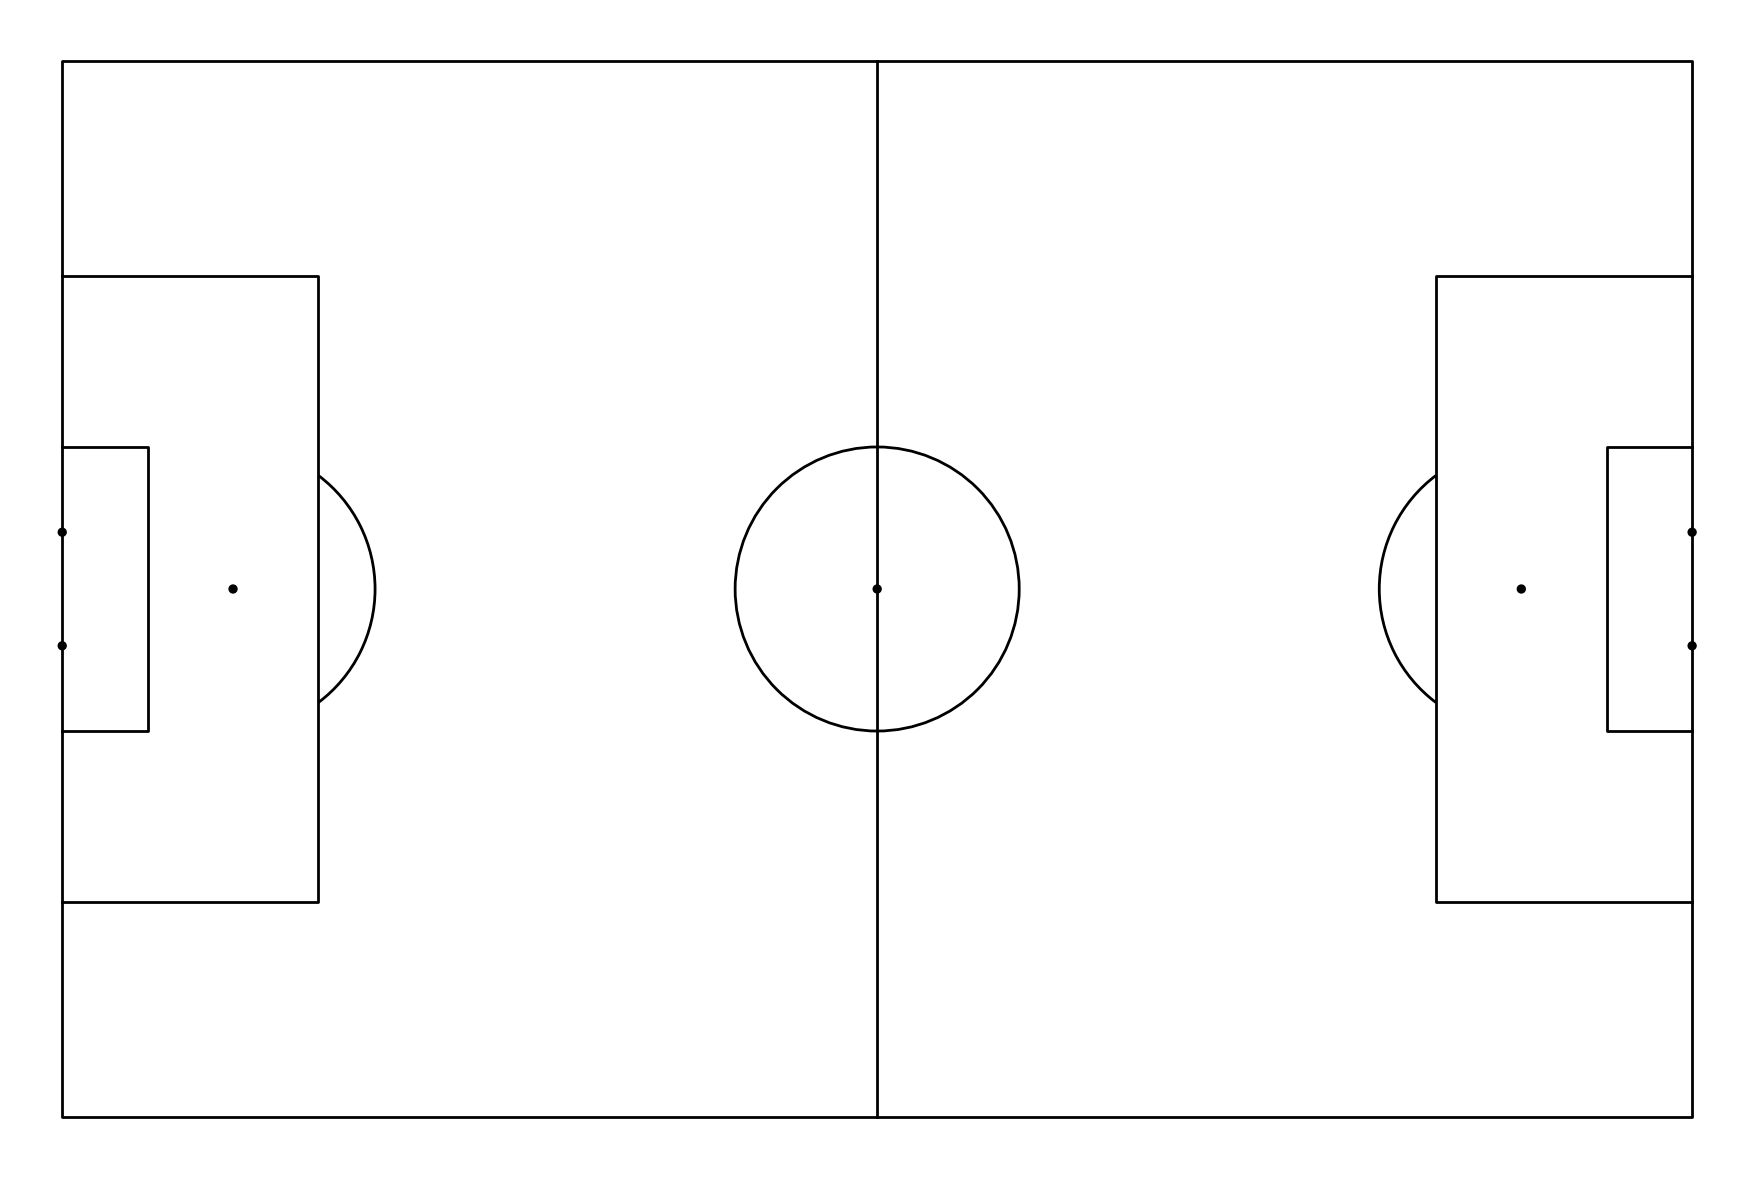

In [33]:
pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)
for i, t in enumerate(adjusted):

    mask = ~np.isnan(t).any(axis=1)
    clean_t = t[mask]

    if len(clean_t):
        ellipse = confidence_region(clean_t, confidence_level=0.75)
        e = Ellipse(**ellipse, alpha=0.3)
        ax.add_artist(e)

And now we plot! Pretty straight forward; feeding the ellipse attributes into a `Ellipse` object and attaching it to the axis.

Notice how you can detect what sort of positional variation individual players have, relative to the rest of your team.

### Plot Tracking Frame

One of the most common things you will do with tracking data is to plot an individual frame to visualize what is going on at a particular moment.

In [35]:
n = 500
frame = df.iloc[n:n+1]
frame_ = df.iloc[n+1:n+2]

For the purpose of this exercise, we are only going to look at frame `500` (and borrow from frame `501` to calculate player displacement and speed).

In [36]:
bp = frame[['ball_x', 'ball_y']].values[0]

We store the ball position in a variable `bp`

In [37]:
hj = np.unique([x.split("_")[1] for x in df.columns if "home" in x])
aj = np.unique([x.split("_")[1] for x in df.columns if "away" in x])

Like in the previous example, we use a list comprehension to grab the jersey numbers for all players on both the `home` and `away` teams and store them in variables `hj` and `aj`.

In [38]:
def team_vectors(f, f_, team, jerseys):
    p, v = [], []
    for j in jerseys:
        pp = f[['{}_{}_x'.format(team, j), '{}_{}_y'.format(team, j)]].values[0]
        pp_ = f_[['{}_{}_x'.format(team, j), '{}_{}_y'.format(team, j)]].values[0]
        if ~np.isnan(pp[0]):
            p.append(pp)
            v.append(pp_ - pp)
    return np.array(p), np.array(v) * frame_rate

This is a helper function for extracting the position and velocity of players belonging to a single team for a pair of sequential frames.

In [39]:
hp, hv = team_vectors(frame, frame_, "home", hj)
ap, av = team_vectors(frame, frame_, "away", aj)

In [56]:
hp.T[0][0]

0.34208

In [52]:
hp.T[0]

array([0.34208, 0.51692, 0.09609, 0.36416, 0.31874, 0.32943, 0.46178,
       0.42934, 0.39962, 0.46043, 0.55401])

Using the `team_vectors` helper function, we generate an array that represents team-player coordinates and displacement vectors.

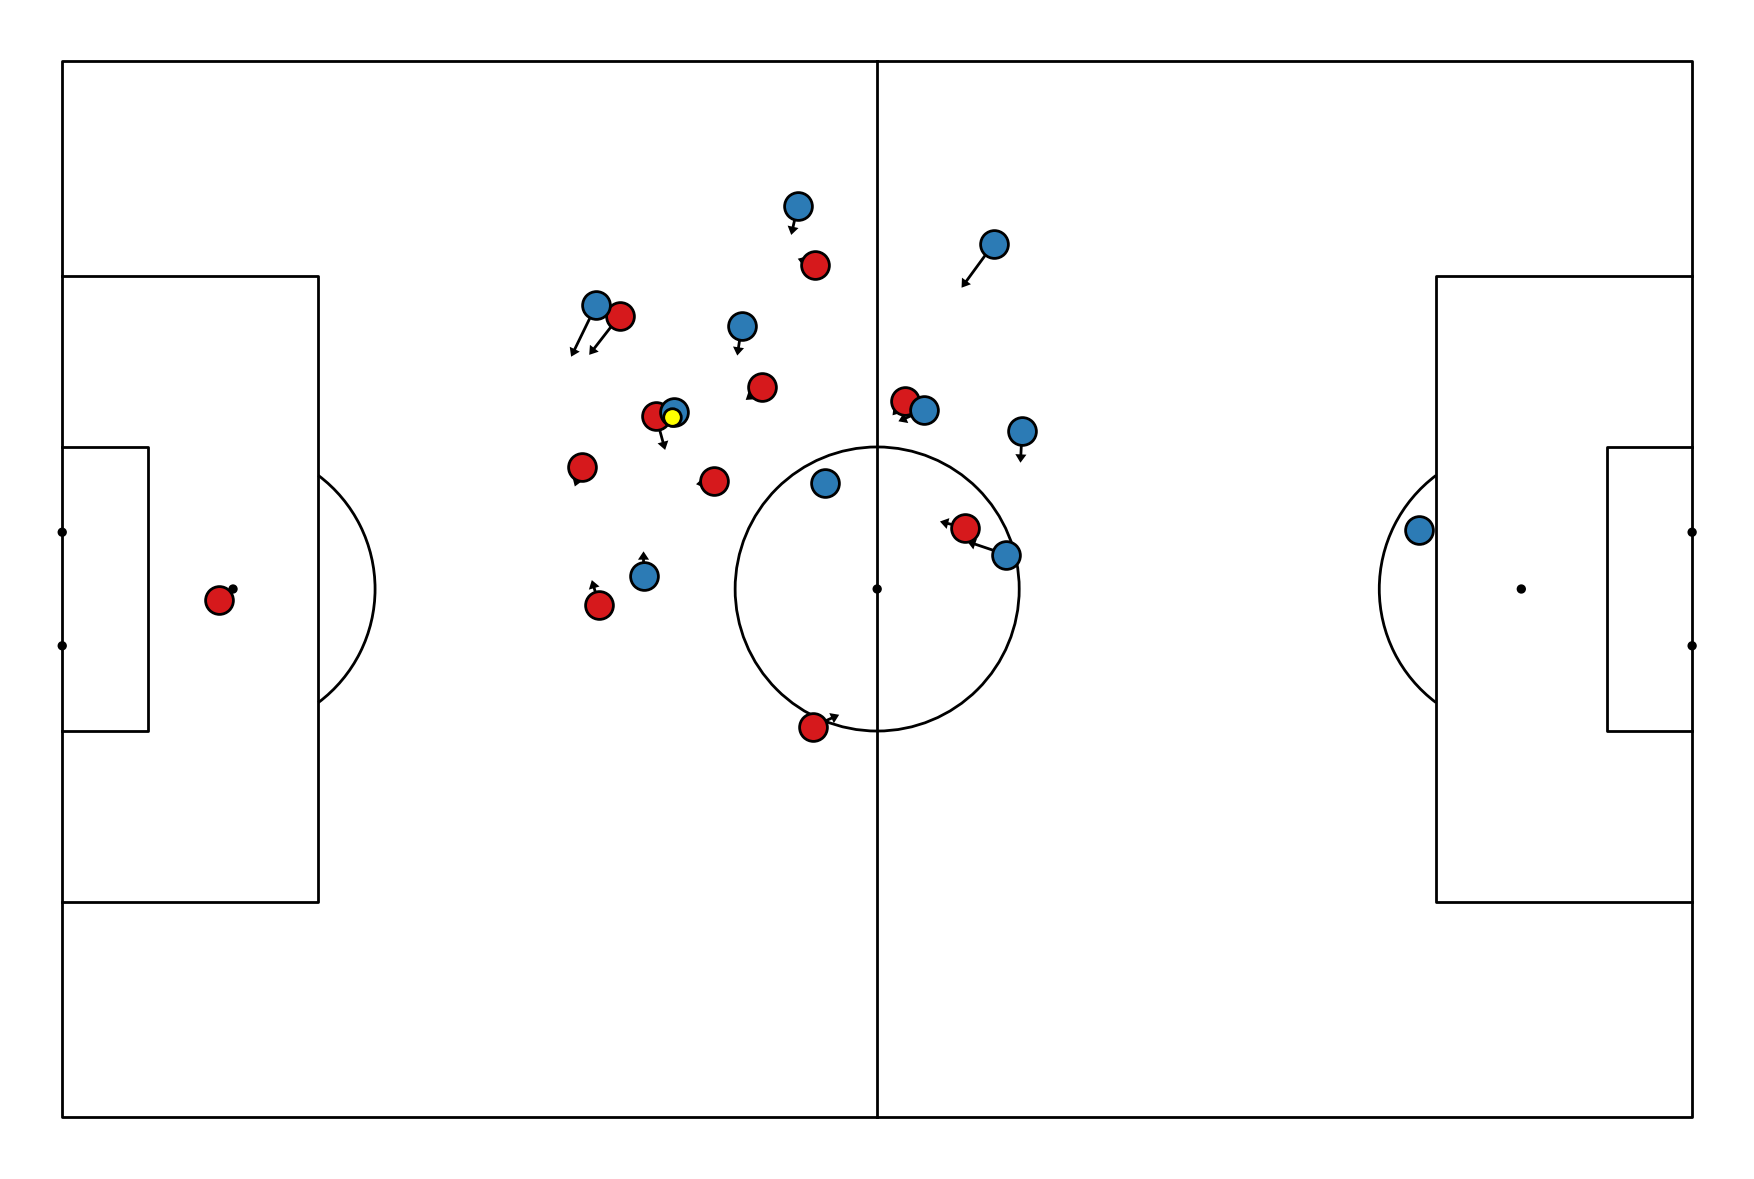

In [60]:
pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)

pitch.arrows(*hp.T, *hp.T + hv.T, ax=ax, color='k', zorder=1,
             headaxislength=3, headlength=3, headwidth=4, width=1)

pitch.arrows(*ap.T, *ap.T + av.T, ax=ax, color='k', zorder=1,
             headaxislength=3, headlength=3, headwidth=4, width=1)

pitch.scatter(*hp.T, ax=ax, facecolor=red, s=100, edgecolor='k')
pitch.scatter(*ap.T, ax=ax, facecolor=blue, s=100, edgecolor='k')
pitch.scatter(*bp.T, ax=ax, facecolor='yellow', s=40, edgecolor='k')

No rocket science here, just plotting the player coordinates and displacement vectors on a `metrica` pitch from `mplsoccer`

### Time to Intercept

Time to Intercept is a foundational component to modern spatial analysis of soccer games, including concepts like Pitch Control from the likes of Will Spearman and Javier Fernandez.

In short, it estimates the time it would take for a player to reach a specific location on the soccer field, given an initial starting velocity. This is a computationally expensive problem to solve exactly (and I'm not even sure how to), so it's common to provide a reasonable estimate. Below I have both Laurie Shaw's approximation, and a small modification of my own.

In [61]:
xx, yy = np.meshgrid(np.linspace(0, length, length*2),
                     np.linspace(0, width, width*2))

indexes = np.stack([xx, yy], 2)

We are going to evaluate `tti` in a grid that has twice as many rows and columns as the soccer field has meters in length and width.

This code generates our `numpy` meshgrid using the field dimensions at the cadence specified in the previous cell.

In [62]:
xx

array([[  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ],
       [  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ],
       [  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ],
       ...,
       [  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ],
       [  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ],
       [  0.        ,   0.50239234,   1.00478469, ..., 103.99521531,
        104.49760766, 105.        ]])

In [63]:
def tti_shaw(origin, destination, velocity,
               reaction_time=0.7, max_velocity=5.0):

    r_reaction = origin + velocity * reaction_time
    d = destination - r_reaction
    return reaction_time + np.linalg.norm(d, axis=-1) / max_velocity

This is the Laurie Shaw `tti` approximation.

In [64]:
def tti(origin, destination, velocity, reaction_time=0.7, max_velocity=5.0):
    u = (origin + velocity) - origin
    v = destination - origin
    u_mag = np.sqrt(np.sum(u**2, axis=-1))
    v_mag = np.sqrt(np.sum(v**2, axis=-1))
    dot_product = np.sum(u * v, axis=-1)
    angle = np.arccos(dot_product / (u_mag * v_mag))
    r_reaction = origin + velocity * reaction_time
    d = destination - r_reaction
    t = (u_mag * angle/np.pi +
         reaction_time +
         np.linalg.norm(d, axis=-1) / max_velocity)

    return t

This is my modification to Laurie's approximation, which incorporates an additional penalty for initial velocities facing away from the target location.

In [65]:
def tti_surface(players, velocities, indexes, tti=tti):
    pvalues = np.empty((players.shape[0], indexes.shape[0], indexes.shape[1]))
    for k in range(players.shape[0]):
        pvalues[k, :, :] = tti(players[k], indexes, velocities[k])
    values = np.amin(pvalues, axis=0)

    return values


This is a lovely piece of code which utilizes `numpy` broadcasting to quickly evaluate `tti` at each cell in the grid, then flattens the many-layered grid into a single layer that represents the minimum value along the vertical axis.

In [66]:
Z_home = tti_surface(hp * adjust, hv * adjust, indexes)
Z_away = tti_surface(ap * adjust, av * adjust, indexes)

We create these `tti` surfaces for both the home and away team. Notice the `adjust` variable, which we use to translate the Metrica coordinate system into a representation where we can rely on euclidian space.

In [67]:
Z = Z_home - Z_away

We subtract the away surface from the home surface to determine which team can reach each cell of the field representation the fastest, and by what margin (in seconds).

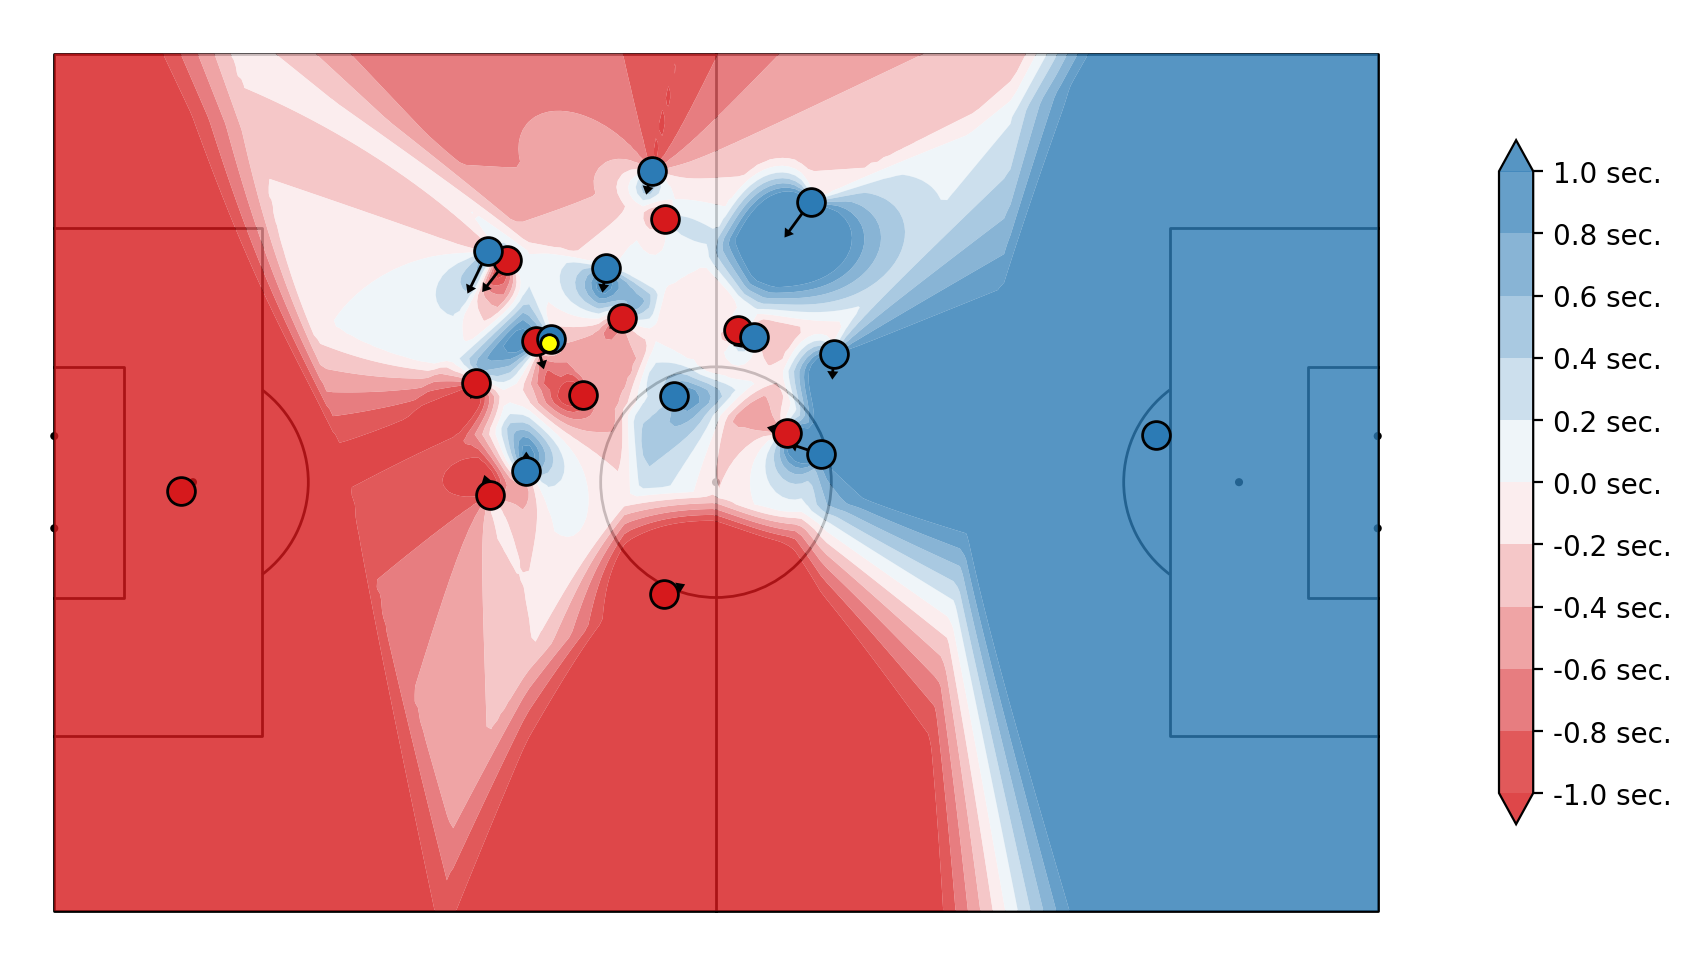

In [68]:
pitch = mpl.Pitch(**metrica_attrs)
fig, ax = pitch.draw(figsize=figsize)
min, max = -1, 1
levels = np.linspace(min, max, 11)
s = ax.contourf(Z, extent=(0,1,0,1), levels=levels,
            cmap=diverging_r, vmin=min, vmax=max, alpha=0.8,
            antialiased=True, extend="both")

pitch.arrows(*hp.T, *hp.T + hv.T, ax=ax, color='k', zorder=1,
             headaxislength=3, headlength=3, headwidth=4, width=1)

pitch.arrows(*ap.T, *ap.T + av.T, ax=ax, color='k', zorder=1,
             headaxislength=3, headlength=3, headwidth=4, width=1)

pitch.scatter(*hp.T, ax=ax, facecolor=red, s=100, edgecolor='k')
pitch.scatter(*ap.T, ax=ax, facecolor=blue, s=100, edgecolor='k')
pitch.scatter(*bp.T, ax=ax, facecolor='yellow', s=40, edgecolor='k')

cbar = plt.colorbar(s, shrink=0.6, ticks=levels)
l = cbar.ax.set_yticklabels(["{:.1f} sec.".format(t) for t in levels])

And we plot it as a filled contour, using a diverging color map.